<img src="./Images/HW06_P01.png" width="700px">

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci 
from scipy.integrate import solve_ivp 


plt.rcParams.update({
    'figure.titlesize': 18,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11
})

In [12]:
# --- Constants --- 
rho_0 = 1.25    # kg/m^3 
g = 9.81    # m/s^2 
y_scale = 10000     # m 

In [28]:
# --- Function to find calculated values --- 
def proj_eqns(t, Y, m, C, A, drag=True): 
    """ 
    Calculate the air density, drag coefficient, and acceleration due to drag
    Arguments: 
        t: time array (required for solve_ivp, not utilized in this specific function)
        Y: array (4) containing the init conditions 
        m: mass of projectile 
        C: air resistance 
        A: cross sectional area of projectile 
        drag (bool): whether or not to include drag effects 
    Returns: 
        [vx, vy, ax, ay]: directional velocity and acceleration 
    """
    x, y, vx, vy = Y    # match each value of Y to its respective param
    
    v = np.hypot(vx, vy)    # total speed (magnitude)
    if drag:
        rho = rho_0 * np.exp(-y/y_scale)    # air density at height y
        D = 0.5 * C * rho * A   # drag coeff at current height 
        ax = -D/m * vx * v  # accel in x dir 
        ay = -g - D/m * vy * v  # accel in y dir 
    else: 
        ax = 0.0
        ay = -g
    
    return [vx, vy, ax, ay]

# --- Event function to tell solver to stop if/when the projectile hits the ground --- 
def ground(t, Y, *args):
    return Y[1]     # height at y(t)
ground.terminal = True  # stop sim when event happens
ground.direction = -1   # look for sign to change from positive to negative 

def run_sim(angle=0.0, v0=0.0, vx0=None, vy0=None, y0=0.0, m=0.0, C=0.0, A=0.0, drag=True, n=350):
    """ 
    Run a projectile motion simulation using solve_ivp 
    Arguments: 
        angle: launch angle in degrees, default 0 -> entry required
        v0: initial velocity (total), default 0 -> entry required
        vx0: initial velocity (x), default None -> entry optional
        vy0: initial velocity (y), default None -> entry optional
        y0: initial height, default 0 -> entry optional 
        m: mass of projectile, default 0 -> entry required
        C: air resistance coefficient, default 0 -> entry required
        A: cross sectional area of projectile, default 0 -> entry required
        drag (bool): include drag or not, default True -> entry optional 
        n: number of steps for plottable array, default 350 -> entry optional 
    Returns: 
        x: x values of solutions 
        y: y values of solutions 
        x_range: distance projectile traveled before landing
        t_ground: how long it took for the projectile to land 
        t_plot: time values to plot over 
    """
    if vx0 is None or vy0 is None:
        theta = np.deg2rad(angle)   #convert angle to radians
        vx0 = v0*np.cos(theta)
        vy0 = v0*np.sin(theta)

    Y0 = [0.0, y0, vx0, vy0]    # put initial conditions into an array for handling
    T = 60  # stopping time for sim
    sol = solve_ivp(proj_eqns, (0, T), Y0, args=(m, C, A, drag), events=ground, dense_output=True)  # run simulation
    t_ground = sol.t_events[0][0]  # define time when projectile landed
    x_range = sol.y_events[0][0,0]  # define distance projectile traveled before landing 
    t_plot = np.linspace(0, t_ground, n)  # create evenly distributed array of values to plot over
    x, y = sol.sol(t_plot)[0], sol.sol(t_plot)[1]  # assign x and y values to the even array 
    return x, y, x_range, t_ground, t_plot

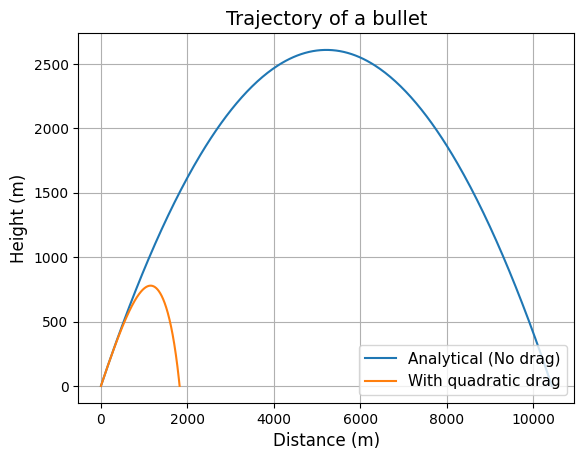

In [62]:
# --- First projectile --- 

# -- params -- 
m1 = 0.011  # kg -> 11.0g
diam1 = 0.0115    # m -> 1.15cm 
A1 = np.pi*((diam1/2)**2)   # cm^2 
C1 = 0.15   # air resistance 
v0_1 = 320  # m/s 

# -- run sim with and without drag at 45 deg -- 
b_x_nodrag, b_y_nodrag, r_b_nodrag, t_b_nodrag, b_time_nd = run_sim(angle=45, v0=v0_1, m=m1, C=C1, A=A1, drag=False)
b_x_drag, b_y_drag, r_b_drag, t_b_drag, b_time_d = run_sim(angle=45, v0=v0_1, m=m1, C=C1, A=A1, drag=True)

# -- plot results -- 
fig, ax = plt.subplots()
ax.set_title("Trajectory of a bullet")
ax.plot(b_x_nodrag, b_y_nodrag, label="Analytical (No drag)")
ax.plot(b_x_drag, b_y_drag, label="With quadratic drag")
ax.set_xlabel("Distance (m)") 
ax.set_ylabel("Height (m)")
ax.legend(loc="lower right")
ax.grid(True)



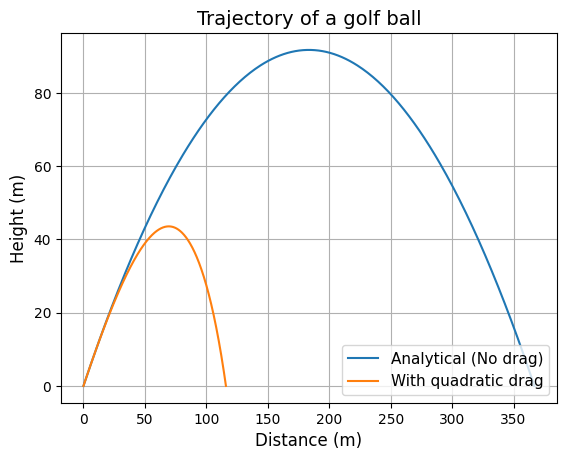

In [63]:
# --- Second projectile --- 

# -- params --
m2 = 0.046   # kg
diam2 = 0.0427    # m
A2 = np.pi*((diam2/2)**2)   # m^2
C2 = 0.50   # air resistance 
v0_2 = 60.  # m/s

# -- run sim with and without drag at 45 deg --
g_x_nodrag, g_y_nodrag, r_g_nodrag, t_g_nodrag, g_time_nd = run_sim(angle=45, v0=v0_2, m=m2, C=C2, A=A2, drag=False)
g_x_drag, g_y_drag, r_g_drag, t_g_drag, g_time_nd = run_sim(angle=45, v0=v0_2, m=m2, C=C2, A=A2, drag=True)

# -- plot -- 
fig, ax = plt.subplots()
ax.set_title("Trajectory of a golf ball")
ax.plot(g_x_nodrag, g_y_nodrag, label="Analytical (No drag)")
ax.plot(g_x_drag, g_y_drag, label="With quadratic drag")
ax.set_xlabel("Distance (m)") 
ax.set_ylabel("Height (m)")
ax.legend(loc="lower right")
ax.grid(True)

In [16]:
# --- Optimal launch angles --- 

def test_range(theta_deg, v0, m, C, A, drag=True):
    theta = np.deg2rad(theta_deg)
    vx0, vy0 = v0*np.cos(theta), v0*np.sin(theta)
    Y0 = [0.0, 1e-6, vx0, vy0]

    T = max(8.0, 1.3*(2*v0*np.sin(theta)/g))
    sol = solve_ivp(proj_eqns, (0,T), Y0, args=(m, C, A, drag), events=ground)

    return sol.y_events[0][0,0]

def best_angle_sweep(v0, m, C, A, drag=True, return_all=False):
    # large sweep 
    thetas = np.arange(10.0, 80.0+1e-9, 2.0)
    ranges = [test_range(th, v0, m, C, A, drag) for th in thetas]
    best_coarse = thetas[int(np.argmax(ranges))]

    # zero in on best coarse angle 
    fine = np.linspace(best_coarse-2.0, best_coarse+2.0, 41)
    fine = fine[(fine>1.0) & (fine<89.0)]
    fine_ranges = [test_range(f, v0, m, C, A, drag) for f in fine]
    th_best = float(fine[int(np.argmax(fine_ranges))])
    r_best = float(np.max(fine_ranges))
    
    return th_best, r_best


th_b_drag, R_b_drag = best_angle_sweep(v0_1, m1, C1, A1, drag=True)
th_g_drag, R_g_drag = best_angle_sweep(v0_2, m2, C2, A2, drag=True)

th_b_nodrag, R_b_nodrag = best_angle_sweep(v0_1, m1, C1, A1, drag=False)
th_g_nodrag, R_g_nodrag = best_angle_sweep(v0_2, m2, C2, A2, drag=False)


print(f"Bullet: drag -- theta = {th_b_drag:.2f}, Max range = {R_b_drag:.0f} m | no drag -- theta = {th_b_nodrag:.2f}, Max range = {R_b_nodrag:.0f} m")
print(f"Golf:   drag -- theta = {th_g_drag:.2f}, Max range = {R_g_drag:.0f} m | no drag -- theta = {th_g_nodrag:.2f}, Max range = {R_g_nodrag:.0f} m")

Bullet: drag -- theta = 34.20, Max range = 1899 m | no drag -- theta = 45.00, Max range = 10438 m
Golf:   drag -- theta = 36.70, Max range = 119 m | no drag -- theta = 45.00, Max range = 367 m


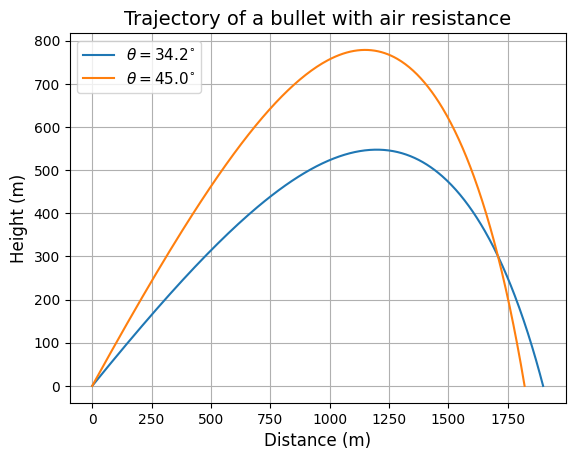

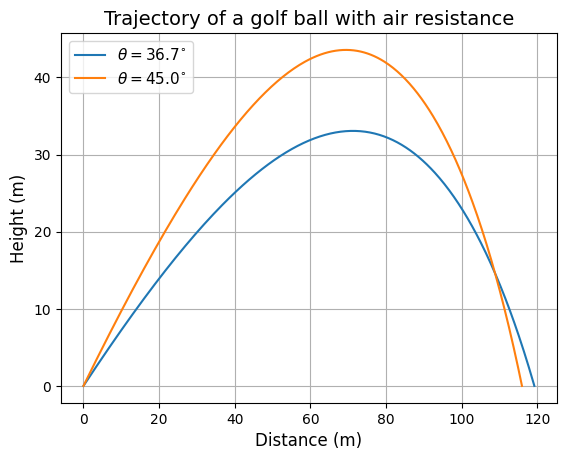

In [64]:

# --- Plot best angle compared to 45 --- 
# -- Bullet --
b_x_best, b_y_best, r_b_best, t_b_best, b_time_best = run_sim(angle=34.20, v0=v0_1, m=m1, C=C1, A=A1, drag=True)
b_x_45, b_y_45, r_b_45, t_b_45, b_time_45 = run_sim(angle=45, v0=v0_1, m=m1, C=C1, A=A1, drag=True)

fig, ax = plt.subplots()
ax.set_title("Trajectory of a bullet with air resistance")
ax.plot(b_x_best, b_y_best, label=r"$\theta = 34.2^{\circ}$")
ax.plot(b_x_45, b_y_45, label=r"$\theta = 45.0^{\circ}$")
ax.set_xlabel("Distance (m)") 
ax.set_ylabel("Height (m)")
ax.legend(loc="upper left")
ax.grid(True)

# -- Golf ball -- 
g_x_best, g_y_best, r_g_best, t_g_best, g_time_best = run_sim(angle=36.70, v0=v0_2, m=m2, C=C2, A=A2, drag=True)
g_x_45, g_y_45, r_g_45, t_g_45, g_time_45 = run_sim(angle=45, v0=v0_2, m=m2, C=C2, A=A2, drag=True)

fig, ax = plt.subplots()
ax.set_title("Trajectory of a golf ball with air resistance")
ax.plot(g_x_best, g_y_best, label=r"$\theta = 36.7^{\circ}$")
ax.plot(g_x_45, g_y_45, label=r"$\theta = 45.0^{\circ}$")
ax.set_xlabel("Distance (m)") 
ax.set_ylabel("Height (m)")
ax.legend(loc="upper left")
ax.grid(True)



--- Bullet ---     
Original v0: 320.00 m/s       
New v0: 326.40 m/s         
Angle: 34.20 (degrees)           
Original distance: 1898.77 m            
New distance: 1923.44 m               
Original max height: 547.63               
New max height: 557.83               
Percent difference: 1.30%               
Percent difference (height): 1.86% 

--- Golf Ball ---     
Original v0: 60.00 m/s       
New v0: 61.20 m/s         
Angle: 36.70 (degrees)           
Original distance: 119.24 m          
Original max height: 33.07             
New max height: 33.84             
New distance: 121.27 m               
Percent difference (distance): 1.70%               
Percent difference (height): 2.34%


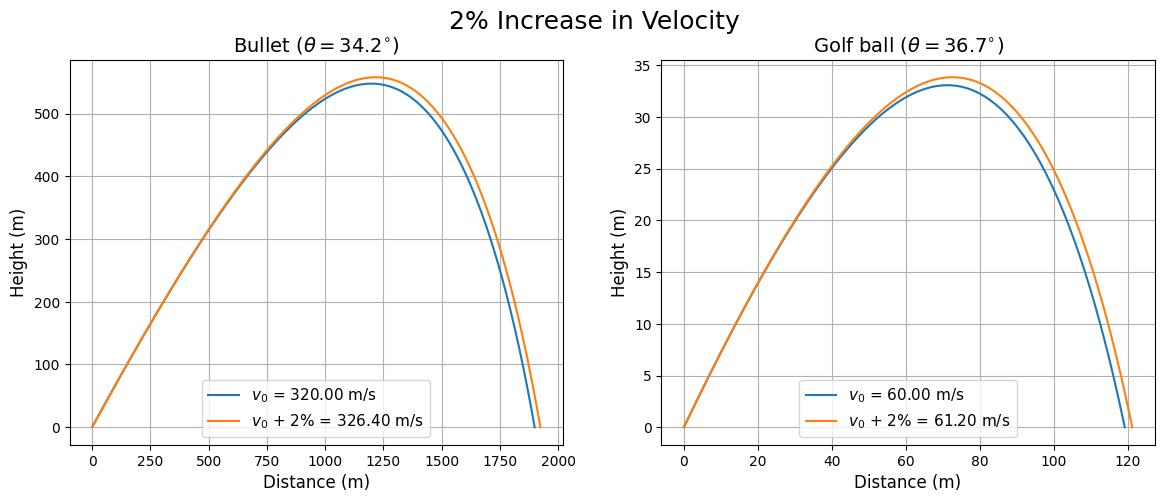

In [ ]:
# --- Increase speed by 2% --- 
# -- bullet -- 
v0_1faster = v0_1 + (v0_1*0.02) 
b_x_faster, b_y_faster, r_b_faster, t_b_faster, b_time_faster = run_sim(angle=th_b_drag, v0=v0_1faster, m=m1, C=C1, A=A1, drag=True)
print(f"--- Bullet --- \
    \nOriginal v0: {v0_1:.2f} m/s \
    \nNew v0: {v0_1faster:.2f} m/s \
    \nAngle: {th_b_drag:.2f} (degrees) \
    \nOriginal distance: {r_b_best:.2f} m\
    \nNew distance: {r_b_faster:.2f} m \
    \nOriginal max height: {max(b_y_best):.2f} \
    \nNew max height: {max(b_y_faster):.2f} \
    \nPercent difference: {(np.abs(r_b_faster-r_b_best)/r_b_best)*100:.2f}% \
    \nPercent difference (height): {(np.abs(max(b_y_best) - max(b_y_faster))/max(b_y_best)*100):.2f}% ")

# -- golf ball -- 
v0_2faster = v0_2 + (v0_2*0.02)
g_x_faster, g_y_faster, r_g_faster, t_g_faster, g_time_faster = run_sim(angle=th_g_drag, v0=v0_2faster, m=m2, C=C2, A=A2, drag=True)
print(f"\n--- Golf Ball --- \
    \nOriginal v0: {v0_2:.2f} m/s \
    \nNew v0: {v0_2faster:.2f} m/s \
    \nAngle: {th_g_drag:.2f} (degrees) \
    \nOriginal distance: {r_g_best:.2f} m\
    \nOriginal max height: {max(g_y_best):.2f} \
    \nNew max height: {max(g_y_faster):.2f} \
    \nNew distance: {r_g_faster:.2f} m \
    \nPercent difference (distance): {(np.abs(r_g_faster-r_g_best)/r_g_best)*100:.2f}% \
    \nPercent difference (height): {(np.abs(max(g_y_best) - max(g_y_faster))/max(g_y_best)*100):.2f}%")

# --- plot differences --- 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

ax1.set_xlabel("Distance (m)")
ax2.set_xlabel("Distance (m)")
ax1.set_ylabel("Height (m)")
ax2.set_ylabel("Height (m)")
ax1.set_title(r"Bullet ($\theta = 34.2^{\circ}$)")
ax2.set_title(r"Golf ball ($\theta = 36.7^{\circ}$)")
plt.suptitle("2% Increase in Velocity")

ax1.plot(b_x_best, b_y_best, label=fr"$v_0$ = {v0_1:.2f} m/s")
ax1.plot(b_x_faster, b_y_faster, label=fr"$v_0$ + 2% = {v0_1faster:.2f} m/s")
ax2.plot(g_x_best, g_y_best, label=fr"$v_0$ = {v0_2:.2f} m/s")
ax2.plot(g_x_faster, g_y_faster, label=fr"$v_0$ + 2% = {v0_2faster:.2f} m/s")
ax1.legend()
ax2.legend()
ax1.grid(True)
ax2.grid(True)
plt.show()

--- Time to hit ground (With Drag) ---       
Dropped: 0.64 s       
Fired: 0.66 s       
Distance (Fired): 192.72 m

--- Time to hit ground (No Drag) ---       
Dropped: 0.64 s       
Fired: 0.64 s       
Distance (Fired): 204.34 m


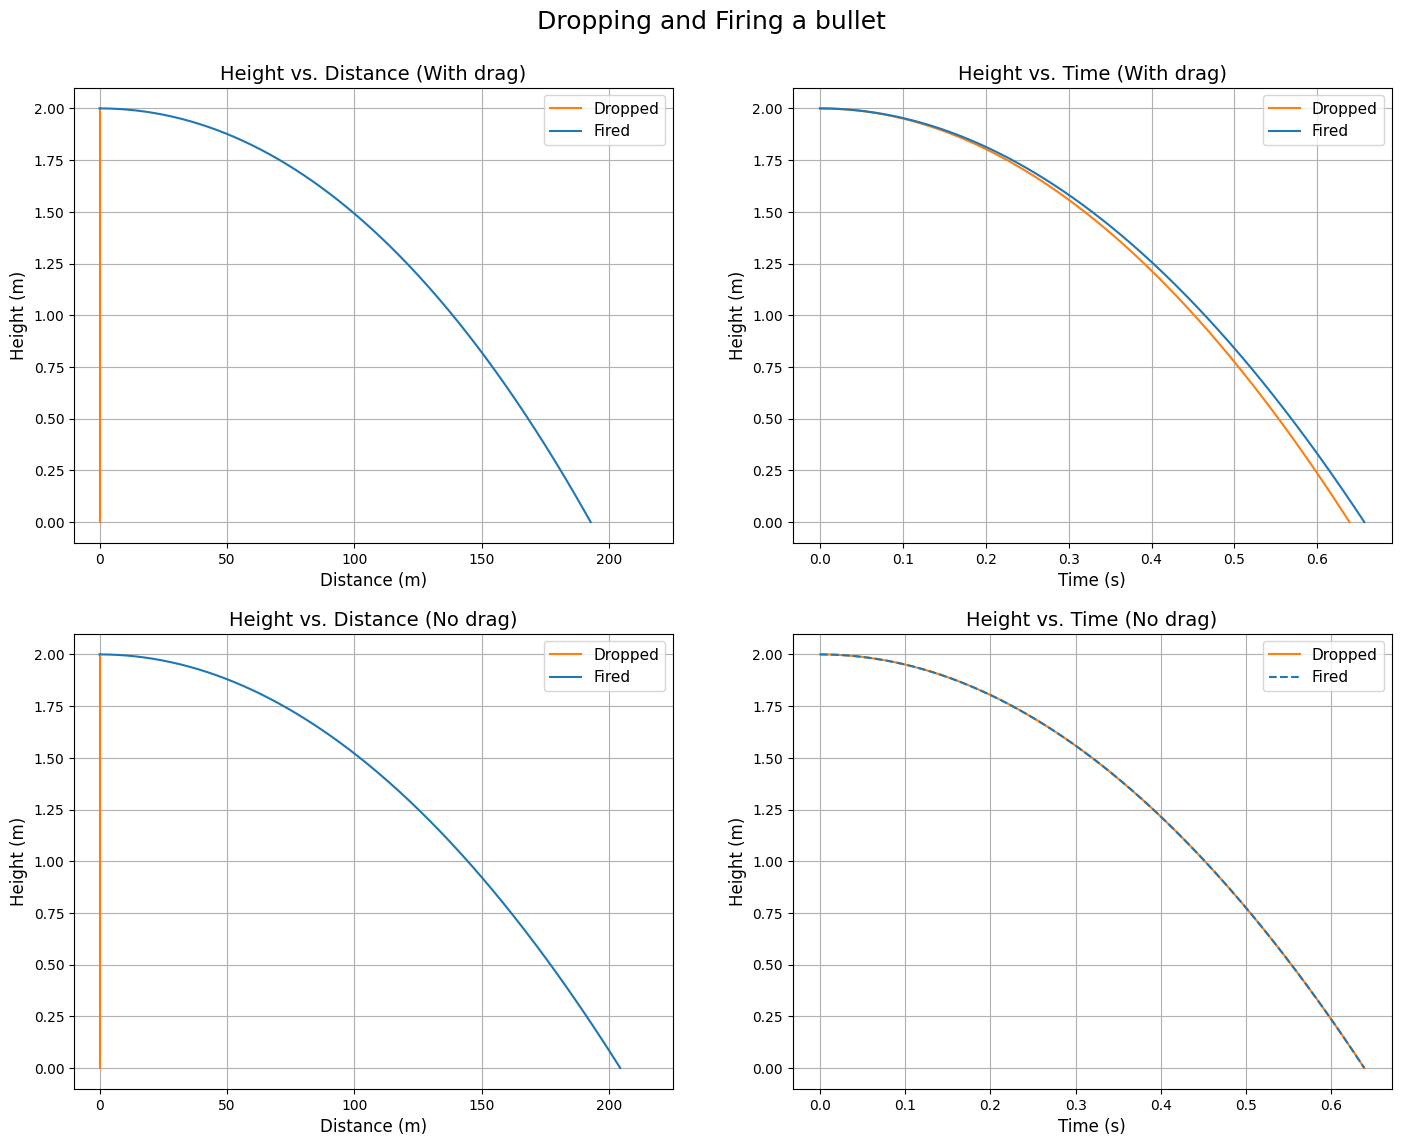

In [76]:
# --- Dropping vs Shooting --- 
b_drop_x, b_drop_y, r_b_drop, t_b_drop, b_time_drop = run_sim(angle=90, v0=0, y0=2.0, m=m1, C=C1, A=A1, drag=True)
b_fire_x, b_fire_y, r_b_fire, t_b_fire, b_time_fire = run_sim(angle=0, v0=320, y0=2.0, m=m1, C=C1, A=A1, drag=True)

b_drop_x_nd, b_drop_y_nd, r_b_drop_nd, t_b_drop_nd, b_time_drop_nd = run_sim(angle=90, v0=0, y0=2.0, m=m1, C=C1, A=A1, drag=False)
b_fire_x_nd, b_fire_y_nd, r_b_fire_nd, t_b_fire_nd, b_time_fire_nd = run_sim(angle=0, v0=320, y0=2.0, m=m1, C=C1, A=A1, drag=False)

print(f"--- Time to hit ground (With Drag) --- \
      \nDropped: {t_b_drop:.2f} s \
      \nFired: {t_b_fire:.2f} s \
      \nDistance (Fired): {r_b_fire:.2f} m")
print(f"\n--- Time to hit ground (No Drag) --- \
      \nDropped: {t_b_drop_nd:.2f} s \
      \nFired: {t_b_fire_nd:.2f} s \
      \nDistance (Fired): {r_b_fire_nd:.2f} m")

fig, axes = plt.subplots(2,2, figsize=(17,13))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

plt.suptitle("Dropping and Firing a bullet", y=0.94)
ax1.set_title("Height vs. Distance (With drag)")
ax2.set_title("Height vs. Time (With drag)")
ax3.set_title("Height vs. Distance (No drag)")
ax4.set_title("Height vs. Time (No drag)")

ax1.set_xlabel("Distance (m)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Distance (m)")
ax4.set_xlabel("Time (s)")

ax1.set_ylabel("Height (m)")
ax2.set_ylabel("Height (m)")
ax3.set_ylabel("Height (m)")
ax4.set_ylabel("Height (m)")



ax1.plot(b_drop_x, b_drop_y, 'C1', label="Dropped")
ax1.plot(b_fire_x, b_fire_y, 'C0', label="Fired")

ax2.plot(b_time_drop, b_drop_y, 'C1', label="Dropped")
ax2.plot(b_time_fire, b_drop_y, 'C0', label="Fired")

ax3.plot(b_drop_x_nd, b_drop_y_nd, 'C1', label="Dropped")
ax3.plot(b_fire_x_nd, b_fire_y_nd, 'C0', label="Fired")

ax4.plot(b_time_drop_nd, b_drop_y_nd, 'C1', label="Dropped")
ax4.plot(b_time_fire_nd, b_fire_y_nd, 'C0', linestyle="--", label="Fired")

ax1.set_xbound(-10, 225)
ax3.set_xbound(-10, 225)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)

plt.show()